In [1]:
# Cell 1 — Imports & setup
import math, time
import numpy as np
import torch
import matplotlib.pyplot as plt

torch.set_grad_enabled(False)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


In [2]:
# Cell 2 — Utilities: grid, HSV->RGB, roots, colorizer

def make_grid(xlim, ylim, width, height, device, cdtype=torch.complex64, fdtype=torch.float32):
    """Create a complex grid Z of shape (H, W) covering [xlim] x [ylim]."""
    ys = torch.linspace(ylim[0], ylim[1], height, device=device, dtype=fdtype)
    xs = torch.linspace(xlim[0], xlim[1], width,  device=device, dtype=fdtype)
    Y, X = torch.meshgrid(ys, xs, indexing='ij')  # (H,W)
    return (X + 1j * Y).to(cdtype)

def hsv_to_rgb_torch(h, s, v):
    """HSV->RGB for tensors. h,s,v in [0,1]. Returns r,g,b in [0,1]."""
    h = h % 1.0
    i = torch.floor(h * 6.0).to(torch.int64)
    f = h * 6.0 - i.to(torch.float32)
    p = v * (1.0 - s)
    q = v * (1.0 - f * s)
    t = v * (1.0 - (1.0 - f) * s)

    r = torch.zeros_like(v); g = torch.zeros_like(v); b = torch.zeros_like(v)
    i_mod = i % 6
    m0 = i_mod.eq(0); m1 = i_mod.eq(1); m2 = i_mod.eq(2)
    m3 = i_mod.eq(3); m4 = i_mod.eq(4); m5 = i_mod.eq(5)

    r = torch.where(m0, v, r); g = torch.where(m0, t, g); b = torch.where(m0, p, b)
    r = torch.where(m1, q, r); g = torch.where(m1, v, g); b = torch.where(m1, p, b)
    r = torch.where(m2, p, r); g = torch.where(m2, v, g); b = torch.where(m2, t, b)
    r = torch.where(m3, p, r); g = torch.where(m3, q, g); b = torch.where(m3, v, b)
    r = torch.where(m4, t, r); g = torch.where(m4, p, g); b = torch.where(m4, v, b)
    r = torch.where(m5, v, r); g = torch.where(m5, p, g); b = torch.where(m5, q, b)

    return r, g, b

def roots_of_unity(n, device, cdtype=torch.complex64):
    k = torch.arange(n, device=device, dtype=torch.float32)
    ang = 2.0 * math.pi * k / n
    return torch.exp(1j * ang.to(cdtype))  # (n,)

def colorize(root_idx, hit_iter, n, max_iters):
    """Map root index + iteration count to an RGB image (H,W,3) in [0,1]."""
    idx_f = root_idx.to(torch.int32)
    it_f  = hit_iter.to(torch.float32)

    H = (idx_f % max(1, n)).to(torch.float32) / float(max(1, n))  # hue per root
    S = (idx_f >= 0).to(torch.float32)                             # 0 if unclassified
    V = 1.0 - 0.9 * (it_f / max(1.0, float(max_iters)))            # faster -> brighter

    # Unclassified -> light gray
    un = idx_f < 0
    H = torch.where(un, torch.zeros_like(H), H)
    V = torch.where(un, torch.full_like(V, 0.85), V)

    r, g, b = hsv_to_rgb_torch(H, S, V)
    rgb = torch.stack([r, g, b], dim=-1)  # (H,W,3)
    return rgb.clamp(0, 1)

In [3]:
# Cell 3 — Core Newton fractal for f(z) = z^n - 1

def newton_fractal_zn_minus_1(n=3, width=1400, height=1400,
                              xlim=(-2.0, 2.0), ylim=(-2.0, 2.0),
                              max_iters=60, tol=1e-6, damping=1.0,
                              device=device, cdtype=torch.complex64):
    """Compute root indices and iteration counts for Newton's method on f(z)=z^n-1."""
    z = make_grid(xlim, ylim, width, height, device, cdtype)  # (H,W)
    H, W = z.shape

    roots = roots_of_unity(n, device, cdtype)  # (n,)
    root_idx = torch.full((H, W), -1, device=device, dtype=torch.int16)
    hit_iter = torch.full((H, W), max_iters, device=device, dtype=torch.int16)
    alive    = torch.ones((H, W), device=device, dtype=torch.bool)

    eps = torch.tensor(1e-12, device=device, dtype=torch.float32)
    start = time.time()

    for k in range(max_iters):
        if not alive.any():
            break

        # Newton step
        fz  = z**n - 1
        dfz = n * (z**(n-1))

        # guard against tiny derivative
        small = (torch.abs(dfz.real) < eps) & (torch.abs(dfz.imag) < eps)
        if small.any():
            dfz = dfz.clone()
            dfz[small] = (eps + 0j).to(cdtype)

        z_new = z - damping * (fz / dfz)
        z = torch.where(alive, z_new, z)

        # Classify newly converged points
        dist = torch.abs(z.unsqueeze(-1) - roots.view(1,1,-1))  # (H,W,n)
        min_dist, min_idx = dist.min(dim=-1)
        newly = alive & (min_dist < tol)
        if newly.any():
            root_idx[newly] = min_idx[newly].to(torch.int16)
            hit_iter[newly] = torch.tensor(k, device=device, dtype=torch.int16)
            alive = alive & (~newly)

    elapsed = time.time() - start
    return root_idx, hit_iter, elapsed

In [ ]:
# Cell 4 — Parameters (tweak these)

N        = 7             # degree in f(z)=z^N - 1
WIDTH    = 1600          # image width
HEIGHT   = 1600          # image height
XLIM     = (-2.0, 2.0)   # real-axis window
YLIM     = (-2.0, 2.0)   # imag-axis window
MAX_IT   = 60            # max Newton iterations
TOL      = 1e-6          # convergence threshold to nearest root
DAMPING  = 1.0           # 0.7–1.0; 1.0 = standard Newton
SAVE_PATH = 'newton_fractal.png'  # set to None to skip saving

Computed in 0.482s on CUDA.


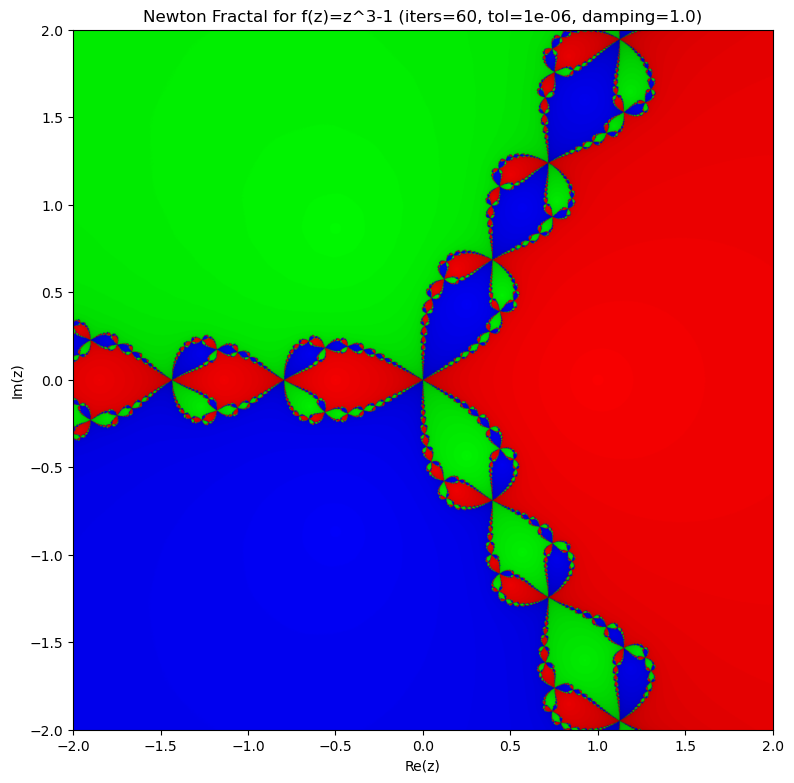

Saved to newton_fractal.png


In [5]:
# Cell 5 — Render

root_idx, hit_iter, t = newton_fractal_zn_minus_1(
    n=N, width=WIDTH, height=HEIGHT,
    xlim=XLIM, ylim=YLIM,
    max_iters=MAX_IT, tol=TOL, damping=DAMPING,
    device=device
)
print(f'Computed in {t:.3f}s on {device.upper()}.')

rgb = colorize(root_idx, hit_iter, n=N, max_iters=MAX_IT).cpu().numpy()

plt.figure(figsize=(8,8))
plt.imshow(rgb, origin='lower', extent=[XLIM[0], XLIM[1], YLIM[0], YLIM[1]])
plt.title(f'Newton Fractal for f(z)=z^{N}-1 (iters={MAX_IT}, tol={TOL}, damping={DAMPING})')
plt.xlabel('Re(z)'); plt.ylabel('Im(z)')
plt.tight_layout()
plt.show()

if SAVE_PATH:
    plt.imsave(SAVE_PATH, rgb, origin='lower')
    print('Saved to', SAVE_PATH)
